**First part of the project**

Implement a standard echo state network (ESN) model, do not include feedback from the output in the ESN state-update equation and do not use leaky-integrator neurons. Implement training of the ESN read-out weights by means of the regularized least-square method. Perform some simulations on the  "lorentz" time series 

**Second part of the project**

Reconstruct and visualize the Lorentz attractor by using states of the ESN implemented in the first part of the project. Feed the implemented ESN model with the time series data in the "lorentz" file and analyze the related sequence of states generated by the ESN model by implemented PCA from scratch.

In [ ]:
import numpy as np
from numpy import arange, array, concatenate, ones, tanh, vstack, zeros

import scipy.linalg as la

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, check_random_state


class SimpleESN(BaseEstimator, TransformerMixin):
    """Simple Echo State Network (ESN)
    Neuron reservoir of sigmoid units, with recurrent connection and random
    weights. Forget factor (or damping) ensure echoes in the network. No
    learning takes place in the reservoir, readout is left at the user's
    convience. The input processed by these ESN should be normalized in [-1, 1]
    Parameters
    ----------
    n_readout : int
        Number of readout neurons, chosen randomly in the reservoir. Determines
        the dimension of the ESN output.
    n_components : int, optional
        Number of neurons in the reservoir, 100 by default.
    damping : float, optional
        Damping (forget) factor for echoes, strong impact on the dynamic of the
        reservoir. Possible values between 0 and 1, default is 0.5
    weight_scaling : float, optional
        Spectral radius of the reservoir, i.e. maximum eigenvalue of the weight
        matrix, also strong impact on the dynamical properties of the
        reservoir. Classical regimes involve values around 1, default is 0.9
    discard_steps : int, optional
        Discard first steps of the timeserie, to allow initialisation of the
        network dynamics.
    random_state : integer or numpy.RandomState, optional
        Random number generator instance. If integer, fixes the seed.
    Attributes
    ----------
    input_weights_ : array_like, shape (n_features,)
        Weight of the input units
    weights_ : array_Like, shape (n_components, n_components)
        Weight matrix for the reservoir
    components_ : array_like, shape (n_samples, 1+n_features+n_components)
        Activation of the n_components reservoir neurons, including the
        n_features input neurons and the bias neuron, which has a constant
        activation.
    readout_idx_ : array_like, shape (n_readout,)
        Index of the randomly selected readout neurons
    Example
    -------
    >>> from simple_esn import SimpleESN
    >>> import numpy as np
    >>> n_samples, n_features = 10, 5
    >>> np.random.seed(0)
    >>> X = np.random.randn(n_samples, n_features)
    >>> esn =SimpleESN(n_readout = 2)
    >>> echoes = esn.fit_transform(X)
    """

    def __init__(self, n_readout, n_components=100, damping=0.5,
                 weight_scaling=0.9, discard_steps=0, random_state=None):
        self.n_readout = n_readout
        self.n_components = n_components
        self.damping = damping
        self.weight_scaling = weight_scaling
        self.discard_steps = discard_steps
        self.random_state = check_random_state(random_state)
        self.input_weights_ = None
        self.readout_idx_ = None
        self.weights_ = None

    def _fit_transform(self, X):
        n_samples, n_features = X.shape
        X = check_array(X, ensure_2d=True)
        self.weights_ = self.random_state.rand(
            self.n_components, self.n_components)-0.5
        spectral_radius = np.max(np.abs(la.eig(self.weights_)[0]))
        self.weights_ *= self.weight_scaling / spectral_radius
        self.input_weights_ = self.random_state.rand(self.n_components,
                                                     1+n_features)-0.5
        self.readout_idx_ = self.random_state.permutation(
            arange(1+n_features,
                   1+n_features+self.n_components))[:self.n_readout]
        self.components_ = zeros(shape=(1+n_features+self.n_components,
                                        n_samples))

        curr_ = zeros(shape=(self.n_components, 1))
        U = concatenate((ones(shape=(n_samples, 1)), X), axis=1)
        for t in range(n_samples):
            u = array(U[t, :], ndmin=2).T
            curr_ = (1-self.damping)*curr_ + self.damping*tanh(
                self.input_weights_.dot(u) + self.weights_.dot(curr_))
            self.components_[:, t] = vstack((u, curr_))[:, 0]
        return self

    def fit(self, X, y=None):
        """Initialize the network
        This is more compatibility step, as no learning takes place in the
        reservoir.
        Parameters
        ----------
        X : array-like shape, (n_samples, n_features)
            The data to be transformed.
        Returns
        self : returns an instance of self.
        """
        self = self._fit_transform(X)
        return self

    def fit_transform(self, X, y=None):
        """Generate echoes from the reservoir.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.
        Returns
        -------
        readout : array, shape (n_samples, n_readout)
            Reservoir activation generated by the readout neurons
        """
        self = self._fit_transform(X)
        return self.components_[self.readout_idx_, self.discard_steps:].T

    def transform(self, X):
        """Generate echoes from the reservoir
        Parameters
        ----------
        X : array-like shape, (n_samples, n_features)
            The data to be transformed.
        Returns
        -------
        readout : array, shape (n_samples, n_readout)
            Reservoir activation generated by the readout neurons
        """
        X = check_array(X, ensure_2d=True)
        n_samples, n_features = X.shape

        if self.weights_ is None:
            self.weights_ = self.random_state.rand(self.n_components,
                                                   self.n_components)-0.5
            spectral_radius = np.max(np.abs(la.eig(self.weights_)[0]))
            self.weights_ *= self.weight_scaling / spectral_radius
        if self.input_weights_ is None:
            self.input_weights_ = self.random_state.rand(self.n_components,
                                                         1+n_features)-0.5
        if self.readout_idx_ is None:
            self.readout_idx_ = self.random_state.permutation(
                arange(1+n_features,
                       1+n_features+self.n_components))[:self.n_readout]
        self.components_ = zeros(shape=(1+n_features+self.n_components,
                                        n_samples))

        curr_ = zeros(shape=(self.n_components, 1))
        U = concatenate((ones(shape=(n_samples, 1)), X), axis=1)
        for t in range(n_samples):
            u = array(U[t, :], ndmin=2).T
            curr_ = (1-self.damping)*curr_ + self.damping*tanh(
                self.input_weights_.dot(u) + self.weights_.dot(curr_))
            self.components_[:, t] = vstack((u, curr_))[:, 0]

        return self.components_[self.readout_idx_, self.discard_steps:].T

MSE ON PREDICTION  0.0038442480104572403


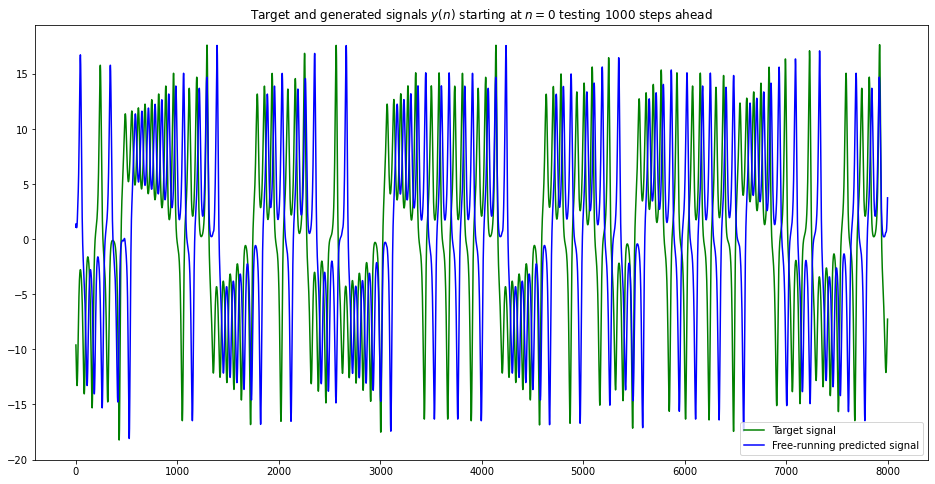

MSE ON PREDICTION  0.007717638432150246


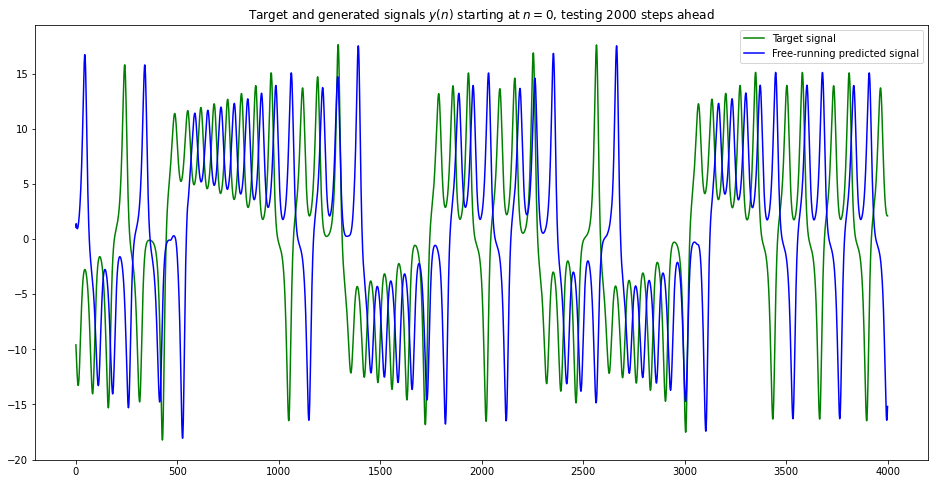

MSE ON PREDICTION  0.00881912806639522


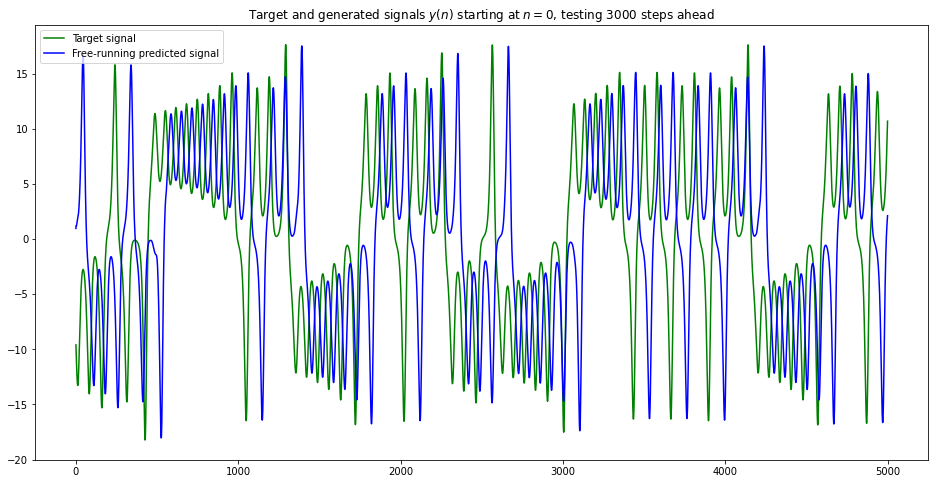

In [ ]:
from pprint import pprint
from time import time

import matplotlib.pyplot as plt

from numpy import atleast_2d, loadtxt

#from simple_esn.simple_esn import SimpleESN

#from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
X = loadtxt('lorentz.txt')
X = atleast_2d(X).T

train_length = 2000
test_length = 8000
X_train = X[:train_length]
y_train = X[1:train_length+1]
X_test = X[train_length:train_length+test_length]
y_test = X[train_length+1:train_length+test_length+1]

# Simple training
my_esn = SimpleESN(n_readout=1000, n_components=1000, damping=0.3, weight_scaling=1.25)
echo_train = my_esn.fit_transform(X_train)
regr = Ridge(alpha=0.00001)
regr.fit(echo_train, y_train)
echo_test = my_esn.transform(X_test)
y_true, y_pred = y_test, regr.predict(echo_test)
err = mean_squared_error(y_true, y_pred)
print("MSE ON PREDICTION  "+ str(err))
plt.figure(figsize = (16,8)).clear()
plt.plot( X[train_length+100:train_length+test_length+100], 'g' )
plt.plot( y_pred, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$ testing 1000 steps ahead')
plt.legend(['Target signal', 'Free-running predicted signal'])
plt.show()

train_length = 2000
test_length = 4000
X_train = X[:train_length]
y_train = X[1:train_length+1]
X_test = X[train_length:train_length+test_length]
y_test = X[train_length+1:train_length+test_length+1]

# Simple training
my_esn = SimpleESN(n_readout=1000, n_components=1000, damping=0.3, weight_scaling=1.25)
echo_train = my_esn.fit_transform(X_train)
regr = Ridge(alpha=0.01)
regr.fit(echo_train, y_train)
echo_test = my_esn.transform(X_test)
y_true, y_pred = y_test, regr.predict(echo_test)
err = mean_squared_error(y_true, y_pred)
print("MSE ON PREDICTION  "+ str(err))
plt.figure(figsize = (16,8)).clear()
plt.plot( X[train_length+100:train_length+test_length+100], 'g' )
plt.plot( y_pred, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$, testing 2000 steps ahead')
plt.legend(['Target signal', 'Free-running predicted signal'])
plt.show()

train_length = 2000
test_length = 5000
X_train = X[:train_length]
y_train = X[1:train_length+1]
X_test = X[train_length:train_length+test_length]
y_test = X[train_length+1:train_length+test_length+1]

# Simple training
my_esn = SimpleESN(n_readout=1000, n_components=1000, damping=0.3, weight_scaling=1.25)
echo_train = my_esn.fit_transform(X_train)
regr = Ridge(alpha=0.01)
regr.fit(echo_train, y_train)
echo_test = my_esn.transform(X_test)
y_true, y_pred = y_test, regr.predict(echo_test)
err = mean_squared_error(y_true, y_pred)
print("MSE ON PREDICTION  "+ str(err))
plt.figure(figsize = (16,8)).clear()
plt.plot( X[train_length+100:train_length+test_length+100], 'g' )
plt.plot( y_pred, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$, testing 3000 steps ahead')
plt.legend(['Target signal', 'Free-running predicted signal'])
plt.show()


In [ ]:
import numpy as np
 
def PCA(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
    
     
    return X_reduced

In [ ]:
import pandas as pd
 

#prepare the data
x2 = echo_test
 
#prepare the target
target = [1,2]
 
#Applying it to PCA function
mat_reduced = PCA(x2 , 2)
 
#Creating a Pandas DataFrame of reduced Dataset
principal_df = pd.DataFrame(mat_reduced , columns = ['PC1','PC2'])
 
#Concat it with target variable to create a complete Dataset
principal_df = pd.concat([principal_df , pd.DataFrame(target)] , axis = 1)

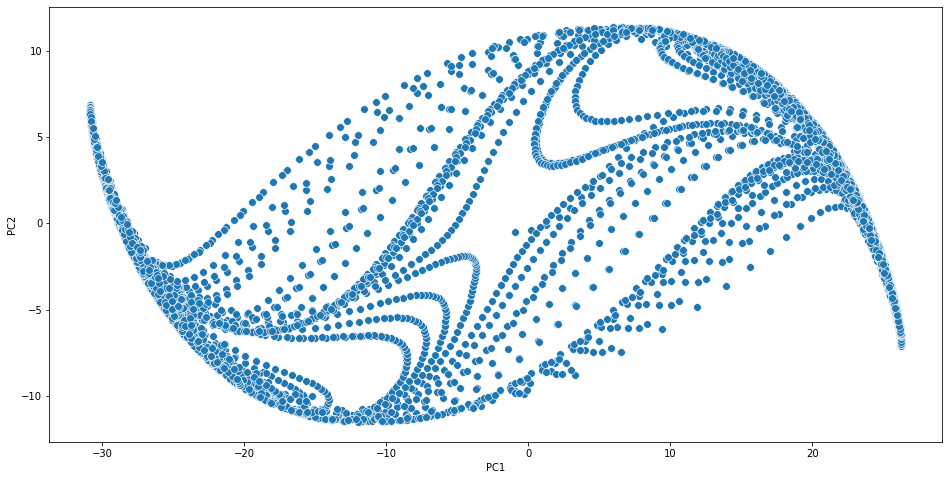

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
 
plt.figure(figsize = (16,8))
sb.scatterplot(data = principal_df , x = 'PC1',y = 'PC2'  , s = 60 , palette= 'icefire')